In [1]:
import pandas as pd
import xarray as xr

from standard_precip.spi import SPI as SPI_Calculator


In [2]:
domain_lat, domain_lon = 33.061179, -108.537275

In [3]:
pdsi_data = xr.open_dataset("data/pdsi.mon.mean.selfcalibrated.nc")

In [4]:
df = pdsi_data.pdsi.sel(lat=domain_lat,lon=domain_lon, method="nearest").to_pandas().to_frame()
df.index = pd.to_datetime(df.index, utc=True)
df

,pdsi
time,
1850-01-01 00:00:00+00:00,-1.811063
1850-02-01 00:00:00+00:00,-1.847457
1850-03-01 00:00:00+00:00,-1.905169
1850-04-01 00:00:00+00:00,-2.143105
1850-05-01 00:00:00+00:00,-2.530822
...,...
2014-08-01 00:00:00+00:00,0.821870
2014-09-01 00:00:00+00:00,2.308060
2014-10-01 00:00:00+00:00,1.903901


<Axes: xlabel='time'>

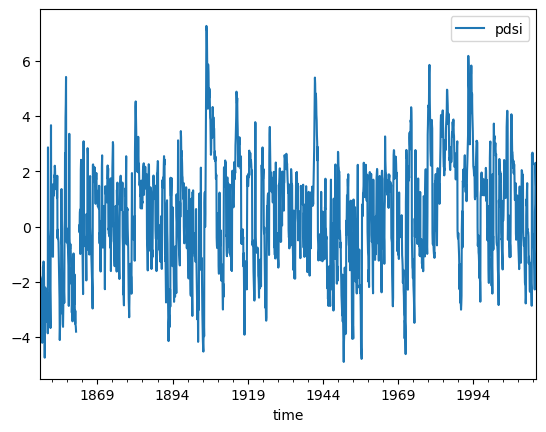

In [5]:
df.plot()

<Axes: xlabel='datetime'>

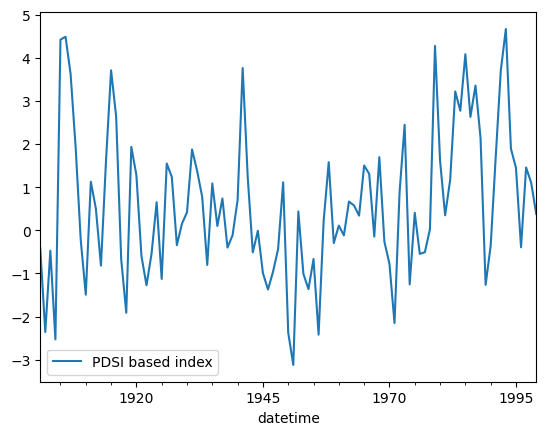

In [6]:
# df.rolling(window=24).mean().plot()
df["PDSI based index"] = df.rolling(window=12).mean()
df["datetime"] = df.index
df["month"] = df["datetime"].dt.month
df["day"] = df["datetime"].dt.day
df["year"] = df["datetime"].dt.year
df = df[df["month"] == 10]
df = df[df["day"] == 1]
df = df[df["year"] > 1900]
df = df[df["year"] < 2000]

df.plot(x="datetime", y = "PDSI based index")

In [7]:
import dataretrieval as dr
from standard_precip.spi import SPI as SPI_Calculator
from standard_precip.utils import plot_index
import numpy as np
import spei as si  # si for standardized index
import pandas as pd
import scipy.stats as scs
import matplotlib.pyplot as plt


In [8]:
# first import the functions for downloading data from NWIS
import dataretrieval.nwis as nwis

# specify the USGS site code for which we want data.

site = '09430500'
# site = "12043300"


# get daily values (dv)
data = nwis.get_record(sites=site, service='dv', start='1900-12-31', end='2020-01-01')
data = data.reset_index()
# data["datetime"] = data.index


# # get basic info about the site
site_info = nwis.get_record(sites=site, service='site')

<Axes: title={'center': 'My Old Drought Index'}, xlabel='datetime'>

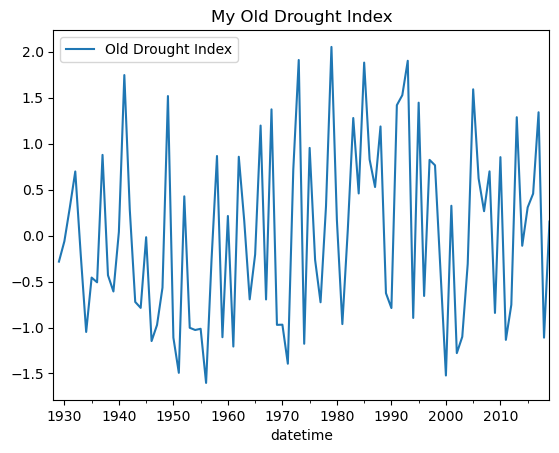

In [9]:
streamflow = "00060_Mean"
discharge_timeseries = data[streamflow]
spi_calculator = SPI_Calculator()
ACCUMULATION_WINDOW_IN_DAYS = 365
# DROUGHT_LENGTH = 365*20
spi = spi_calculator.calculate(
    data, 
    'datetime', 
    streamflow, 
    freq="D", 
    scale=ACCUMULATION_WINDOW_IN_DAYS, 
    fit_type="lmom", 
    dist_type="gev"
)
spi = spi.rename(columns = {f"{streamflow}_scale_{ACCUMULATION_WINDOW_IN_DAYS}_calculated_index": "Old Drought Index"})
# spi.plot(x="datetime", y = f"Old Drought Index")
spi["month"] = spi["datetime"].dt.month
spi["day"] = spi["datetime"].dt.day
spi["year"] = spi["datetime"].dt.year
spi = spi[spi["month"] == 10]
spi = spi[spi["day"] == 1]
spi.plot(x="datetime", y = "Old Drought Index", title="My Old Drought Index")

In [10]:
spi = spi[spi["year"] > 1900]
spi = spi[spi["year"] < 2000]

<Axes: xlabel='datetime'>

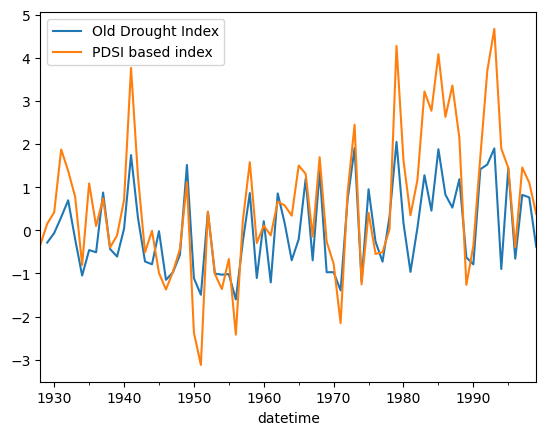

In [11]:
# I want to compare the two drought indices
# I will plot them on the same graph
# I will also calculate the correlation between the two

# I will first merge the two dataframes 
df = pd.merge(spi, df, left_on="datetime", right_on="datetime")
df = df.set_index("datetime")
df = df[["Old Drought Index", "PDSI based index"]]
df.plot()